# Comparative evaluation of sequencer performance 

## Overview of the main insights

#### Golden reference sample is not optimal to evaluate the performance for clinical use
* We cannot evaluate assay performance for each variant intended for clinical use, because golden reference sample does not cover all target regions.

#### SG001_1 yields optimal results on covered target regions
1. Better performance (precision and sensitivity)
2. Better sequence quality (read quality, error rate, coverage)

#### Coverage increase is recommended
* We recommend to increase sequencing depth to achieve a minimal depth of coverage of 250 reads per tested target region to guarantee intended limit of detection in clinical settings

In [1]:
import vcf
import pandas as pd
import numpy as np
import matplotlib
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys

In [2]:
# setup paths 
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

from src.utils.vcf import read_vcf_data, read_vcf_meta, extract_attr, accuracy_metrics
from src.utils.plot import truncate_colormap, make_boxplot, plot_var_venn
from src.utils.plot import plot_nice_barplot, show_samplots_image
from src.utils.msg import print_samstats_message, get_sam_stat, print_samstats_mismatch, print_sams_pairstats
from src import config

## Validating the Golden Reference
The validation of Next-Generation Sequencing–Based gene panels relies on the use of golden reference samples independently assessed for their mutational status. To accurately evaluate the performance of gene panel on different sequencers we need to estimate assay performance for each variant intended for clinical use. Hence, the golder reference should cover fully the target regions.
* Reference sample covers only 94% of targets regions (3 are missing)
  
**Recommendation**  
To validate gene panel performance, a **reference sample covering all target regions is needed**. Regions may vary in sequence context impacting the quality of called variants and sequencing errors. For example, missing regions can be problematic on a given sequencer. Validation on a subset of regions cannot provide for accurate evaluation of panel performance for clinical use.
  
**Action for current analysis**  
To provide for initial evaluation of assay performance, we will filter out target regions that are not included in golden reference.

In [3]:
infile = os.path.join(config.DATA_PROCESSED_PATH, config.BM_STAT)
stats = pd.read_csv(infile, sep="\t").iloc[0]
target_coverage = np.around(stats.Benchmarked_targets/stats.Total_targets*100, 2)
print(f"Gene panel target region coverage: {target_coverage}%")
pd.DataFrame({"Counts": stats})

Gene panel target region coverage: 94.12%


,Counts
Total_targets,51
Benchmarked_targets,48
Missing_targets,3


## Sequencing libraries

#### SG001_1 library contains paired reads, while SG001_2 contains longer single reads

In [4]:
infile = os.path.join(config.DATA_PROCESSED_PATH, config.SAM_STAT)
stats = pd.read_csv(infile, sep="\t")
stats.loc[stats.Attribute.isin(['raw_total_sequences:'])]

print_samstats_message(stats)


Sequencing library SG001_1.bam
Paired 148.0bp reads with 249.7+/-64.5bp average insert size

Sequencing library SG001_2.bam
Single reads with 137.0bp average read length


## Sequencing errors

#### SG001_1 has lower throughput, but higher quality sequences than SG001_2
* SG001_**1** has **lower error** rate
* SG001_**1** has **higher** average read **quality**
* SG001_**2** has **more reads**

In [5]:
print_samstats_mismatch(stats)


Sequencing library SG001_1.bam
Mapped: 6152478.0bp
Mismatched: 17365.0bp
Error-rate: 0.002833427
Average read quality: 36.5
Duplicate reads: 0.0

Sequencing library SG001_2.bam
Mapped: 20288660.0bp
Mismatched: 307892.0bp
Error-rate: 0.01533555
Average read quality: 21.7
Duplicate reads: 0.0


#### Most paired end reads in SG001_1 are properly paired

In [6]:
filename='SG001_1.bam'
print_sams_pairstats(stats.loc[stats.Filename.isin([filename])])


Sequencing library SG001_1.bam
Total paired reads: 41873.0
Proper pairs: 40904.0 (98.0%)
Pairs on different chromsomes 173.0
Inward orientation: 18915.0
Outward orientation: 30.0
Other orientation: 21.0


#### Visual inspection of sequencing errors: SG001_2 is problematic
Sequencing errors were visually inspected in **IGV viewer** generated as **single page html**:
* [IGV viewer](/files/data/processed/igv_viewer.html) - **CLICK** to visualise the alignments in new tab

Visual inspection demonstrates that:
* **SG001_1** contains a few read pair mates aligned on different chromosomes, that **do not pose a challenge for variant calls**
* **SG001_2** is susceptible to a high number of short insertions and deletions that **may lead to false variant calls**


## Coverage Depth and Uniformity

#### SG001_2 generated more reads, but most did not align to the reference
* SG001_2 generated 2.6 times more reads than SG001_1
* SG001_1 has >98% of reads mapped to the reference at a lower error rate than for SG001_2
* SG001_2 has only 65% of reads mapped to the reference at a relatively high error rate

In [7]:
plot_df = dict()
for filename in stats.Filename.unique():
    plot_df[filename] = dict()
    plot_df[filename]["mapped_fraction"] = get_sam_stat(stats, filename, 'reads_mapped:')/get_sam_stat(stats, filename, 'raw_total_sequences:')
    plot_df[filename]["reads_mapped"] = get_sam_stat(stats, filename, 'reads_mapped:')
    plot_df[filename]["reads_total"] = get_sam_stat(stats, filename, 'raw_total_sequences:')
    plot_df[filename]["reads_duplicated"] = get_sam_stat(stats, filename, 'reads_duplicated:')
    plot_df[filename]["error_rate"] = get_sam_stat(stats, filename, 'error_rate:')
pd.DataFrame(plot_df).T.reset_index()

,index,mapped_fraction,reads_mapped,reads_total,reads_duplicated,error_rate
0,SG001_1.bam,0.987844,41365.0,41874.0,0.0,0.002833
1,SG001_2.bam,0.656101,107970.0,164563.0,0.0,0.015336


#### Despite much deeper coverage SG001_2 suffers from non-uniform coverage

* Visual inspection of samplots (in data/processed/samplots/), with the selected examples of target regions shown below.  
* Light gray indicates low quality read coverage (stacked).

##### The problematic taget region on chromosome 19 is not covered by Golden Reference

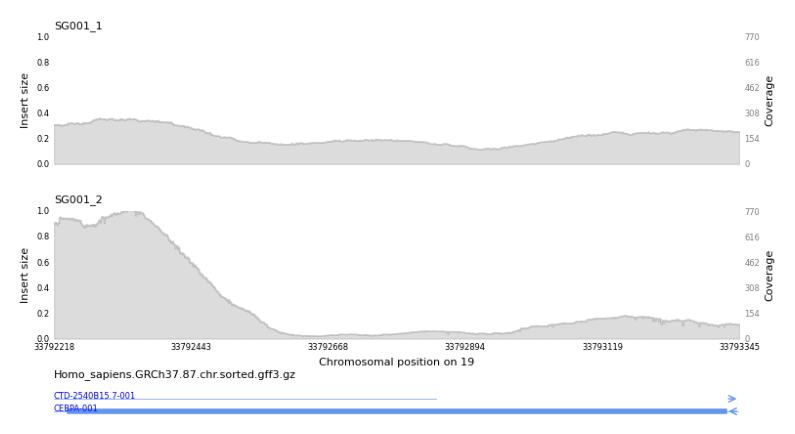

In [8]:
show_samplots_image("19:33792218-33793345.png")

##### The problematic taget region on chromosome 17 is not covered by Golden Reference

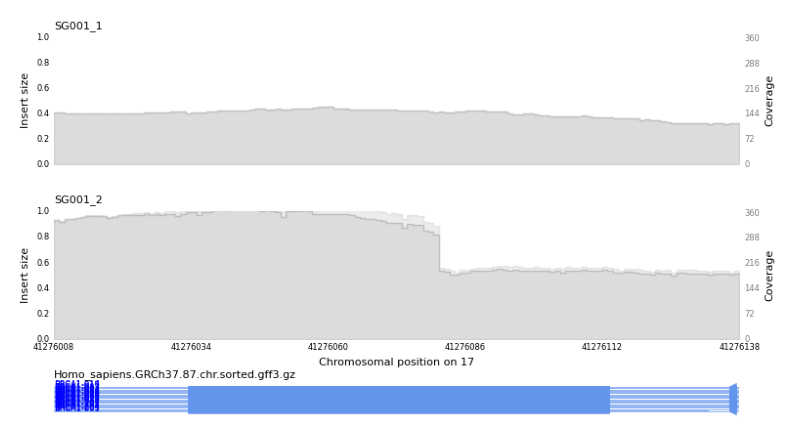

In [9]:
show_samplots_image("17:41276008-41276138.png")

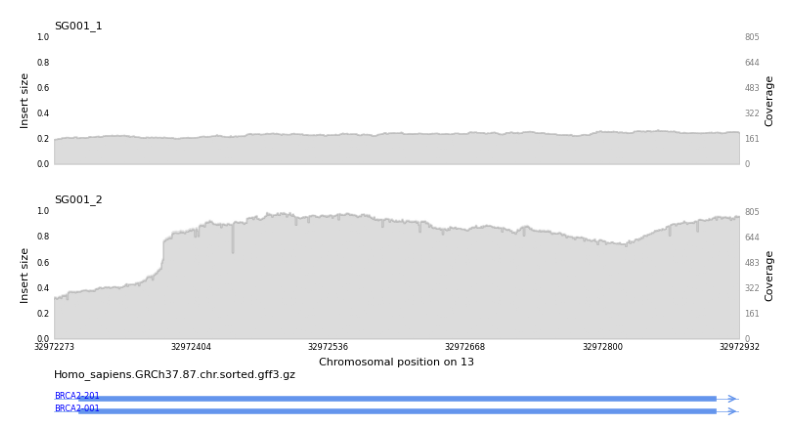

In [10]:
show_samplots_image("13:32972273-32972932.png")

## Variant analysis

1. In clinical context, it is important to make sure that all individuals at risk are identified and taken care of. **Both sequencers achieve 100% sensitivity in target region.**

2. Given that all individuals at risk are identified, it is important to minimise the number of individuals who are not at risk but are wrongly classified as individuals at risk. Misclassification is a big problem, because individuals would undergo severe psychological stress and unnecessary expenses, which is also a burden for healthcare system. **SG001_1 is a better sequencer, achieving 100% precision**.

3. True negatives are not considered, given that the goal is to correctly identify positions with variants. 

#### Genes in target regions
Target regions cover genes BRCA1, BRCA2, SRSF2, CEBPA and pseudogene RPL21P4. Mutations in these genes are associated with an increased cancer risk.

In [11]:
infile = os.path.join(config.DATA_PROCESSED_PATH, config.ANNOTR_TARGET)
target_annot = pd.read_csv(infile, sep='\t', header=None)
target_annot.columns = ['chr', 'start', 'end', 'Gene', 'element','strand']
target_annot.Gene.value_counts()

BRCA2      26
BRCA1      22
CEBPA       1
SRSF2       1
RPL21P4     1
Name: Gene, dtype: int64

#### Only SG001_1 has 100% precision and sensitivity on covered target regions
* Both sequencers have **100% sensitivity** and retrieve 13 benchmarked variants fin target region
* Only SG001_1 has  **100% precision**

In [12]:
ref_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_REF), sep='\t')
target_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_TAR), sep='\t')
common_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_COMMON), sep='\t')

filename = "SG001_1_GT.vcf.gz"
precision, sensitivity, f1 = accuracy_metrics(filename, "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')
df_accuracy = pd.DataFrame({filename:[precision, sensitivity, f1]}, index = ['precision', 'sensitivity', 'f1'])
filename = "SG001_2_GT.vcf.gz"
precision, sensitivity, f1 = accuracy_metrics(filename, "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')
df_accuracy[filename] = [precision, sensitivity, f1]
df_accuracy

,SG001_1_GT.vcf.gz,SG001_2_GT.vcf.gz
precision,100.0,36.11
sensitivity,100.0,100.00
f1,100.0,53.06


In [13]:
label = 'On_target'
sample_vcf="SG001_1_GT.vcf.gz"
ref_vcf="SG001_ref.vcf.gz"
var_stat=target_vars
common_stat=common_vars
compare_to='Target'

ref_tot = var_stat.loc[var_stat.File.isin([ref_vcf]), label].tolist()[0]
sample_tot = var_stat.loc[var_stat.File.isin([sample_vcf]), label].tolist()[0]
TP = common_stat.loc[common_stat.Region.isin([compare_to]) & common_stat.Files.isin([f"{sample_vcf}, reference"]), 'Common_variants'].tolist()[0]
FP = sample_tot-TP
FN = ref_tot-TP

precision=np.around((TP/(TP+FP))*100, 2)
sensitivity=np.around((TP/(TP+FN))*100, 2)
f1=2*((sensitivity*precision)/(sensitivity+precision))


#### SG001_1 retrieves all variants from Golden reference that fall within target regions without false positives
* SG001_1 has **0 False Positives**
* SG001_2 has **23 False Positives** (explained by higher sequencing error and lower quality)

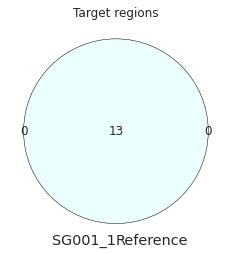

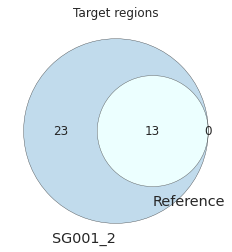

In [14]:
plot_var_venn("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')
plot_var_venn("SG001_2_GT.vcf.gz", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')

#### Considering all reference regions, SG001_1 achieves 2 times better precision 
Given that protocols for target enrichment capture also flanking regions, looking at sequencer performance in a broader context can brings additional information. As expected SG001_1_GT outperforms SG001_2 at very rate of false positives.  

As these are not target regions we do not look at False Negatives here, hence only Precision metric is valid.

In [15]:
precision, sensitivity, f1 = accuracy_metrics("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')
df_accuracy = pd.DataFrame({"SG001_1_GT.vcf.gz":[precision]}, index = ['precision'])
precision, sensitivity, f1 = accuracy_metrics("SG001_2_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')
df_accuracy["SG001_2_GT.vcf.gz"] = [precision]
df_accuracy

,SG001_1_GT.vcf.gz,SG001_2_GT.vcf.gz
precision,97.22,49.06


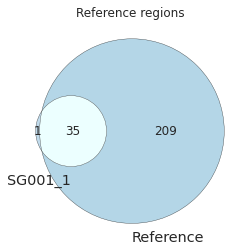

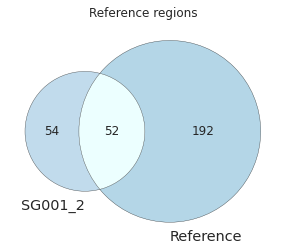

In [16]:
plot_var_venn("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')
plot_var_venn("SG001_2_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')

#### Considering all called variants in each library, SG001_1 has better mapping quality and lower background noise than SG001_2

In [17]:
var_dict = {}
info_dict= {}
filter_dict = {}

for filename in ['SG001_1_GT_target.vcf', 'SG001_2_GT_target.vcf', 'SG001_ref_target.vcf']:
    vcf_dict, samples = read_vcf_data(os.path.join(config.DATA_INTERIM_PATH, filename))
    var_dict[config.PRETTY_NAMES[filename]] = vcf_dict
    
for filename in ['SG001_1_GT.vcf.gz', 'SG001_2_GT.vcf.gz']:
    vcf_info, vcf_filters = read_vcf_meta(os.path.join(config.DATA_RAW_PATH, filename))
    info_dict[config.PRETTY_NAMES[filename]] = vcf_info
    filter_dict[config.PRETTY_NAMES[filename]] = vcf_filters

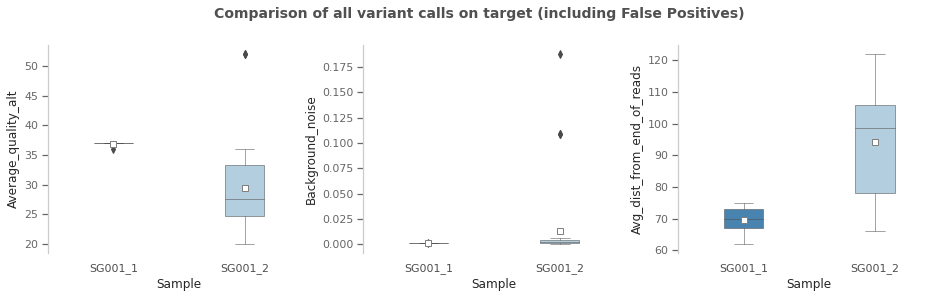

In [18]:
target_cols = ["Average_quality_alt", "Background_noise", "Avg_dist_from_end_of_reads"]

df1 = extract_attr(var_dict, info_dict, "QA", "Average_quality_alt", "SG001_1", as_list=True)
df2 = extract_attr(var_dict, info_dict, "QA", "Average_quality_alt", "SG001_2", as_list=True)
df_stats = pd.concat([df1, df2]).reset_index(drop=True)

df1 = extract_attr(var_dict, info_dict, "BGN", "Background_noise", "SG001_1", as_list=True)
df2 = extract_attr(var_dict, info_dict, "BGN", "Background_noise", "SG001_2", as_list=True)
df_merge = pd.concat([df1, df2]).reset_index(drop=True)
df_stats["Background_noise"] = df_merge["Background_noise"]

df1 = extract_attr(var_dict, info_dict, "DEA", "Avg_dist_from_end_of_reads", "SG001_1", as_list=True)
df2 = extract_attr(var_dict, info_dict, "DEA", "Avg_dist_from_end_of_reads", "SG001_2", as_list=True)
df_merge = pd.concat([df1, df2]).reset_index(drop=True)
df_stats["Avg_dist_from_end_of_reads"] = df_merge["Avg_dist_from_end_of_reads"]

for col in target_cols:
    df_stats[col] = df_stats[col].astype(float)
    
make_boxplot(df_stats, "Sample", target_cols, main_title="Comparison of all variant calls on target (including False Positives)")

## Conclusion: SG001_1 is a better sequencing library 
* Better performance (precision and sensitivity)
* Better quality reads
* Lower error rate
* Uniform coverage

**Further impovements**  
* It is critical to evaluate all target regions for performance, hence an update of golden reference sample is strongly recommended
* Increase sequencing depth to achieve a minimal depth of coverage of 250 reads per tested target region
* Overall, it is recommended to redo variant calls using the latest human genome reference release